In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook will use a GPU. 

You may execute it using the CPU only if you are on a laptop (that should work)

You may also use:
* https://www.crestle.com (pay per use -- reasonable similar pricing (storage may be free?))
* https://www.paperspace.com/pricing (subscribe or pay per use, $\$0.59$/hr GPU and $\$5$/month storage)
* AWS deep learning instance using your free AWS hours?

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

We will again use digits, this time with a MLP and then a CNN

In [3]:
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST

In [4]:
training_data = MNIST('./mndist', train=True,  download=True, transform=ToTensor())
test_data = MNIST('./mndist', train=False,  download=True, transform=ToTensor())

Processing...
Done!


In [5]:
from torch.utils.data import DataLoader

Hyperparameters

In [6]:
BATCH_SIZE = 256
LEARNING_RATE = 0.01
WORKERS = 10

In [7]:
train_loader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True)
test_loader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True)

In [8]:
class MultiLayer(nn.Module):
    def __init__(self, shape=(28,28), num_classes=10):
        super().__init__()
        
        num_inputs = np.product(shape)
        #run it through a linear transformation y = mx + b
        self.layer1 = nn.Linear(num_inputs,50)
        self.layer2 = nn.Linear(50,100)
        self.layer3 = nn.Linear(100,num_classes)
        
    
    def forward(self, x):
        
        #Conv up here 
        
        x = x.reshape(x.shape[0], -1)
        h1 = self.layer1(x)
        h1 = F.relu(h1)
        h2 = self.layer2(h1)
        h2 = F.relu(h2)
        y = self.layer3(h2)
        
        return y  # Will learn to treat 'a' as the natural parameters of a multinomial distr. 

In [9]:
net = MultiLayer()

In [10]:
net

MultiLayer(
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=10, bias=True)
)

In [11]:
list(net.state_dict())

['layer1.weight',
 'layer1.bias',
 'layer2.weight',
 'layer2.bias',
 'layer3.weight',
 'layer3.bias']

## GPU (If Available)

In [12]:
import torch.cuda
torch.cuda.is_available()

False

In [13]:
if torch.cuda.is_available():
    def togpu(x):
        return x.cuda()
    def tocpu(x):
        return x.cpu()
else:
    def togpu(x):
        return x
    def tocpu(x):
        return x

In [14]:
net = togpu(net)

##  Setup loss & Optimizer __after__ net is put on GPU
The network must _already_ be on the GPU, otherwise the tensors that represent the parameters will be the CPU versions and _not_ the GPU version. See the call to `net.parameters()`

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
optimizer = torch.optim.SGD(params=net.parameters(), lr=LEARNING_RATE)

# Training Loop

In [27]:
#pronounced epic
num_epochs = 5

In [28]:
import time

In [29]:
#!pip install tqdm

In [30]:
import tqdm

In [31]:
for epoch in tqdm.tnrange(num_epochs):
    
    running_loss = 0.0
    tstart = time.time()
    for i, data in tqdm.tqdm(enumerate(train_loader),
                             file=sys.stdout,
                             total=len(train_loader), 
                             leave=False):
        # get the inputs
        inputs, labels = data

        # Move inputs to the GPU
        inputs = togpu(inputs)
        labels = togpu(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
    tend = time.time()
    print("Epoch {: 4}   loss: {: 2.5f}  time: {}".format(epoch, 
                                                          running_loss / len(train_loader), 
                                                          tend-tstart))

Epoch    0   loss:  1.62665  time: 1.7271578311920166
Epoch    1   loss:  1.01192  time: 1.5139029026031494
Epoch    2   loss:  0.71943  time: 1.5434620380401611
Epoch    3   loss:  0.58309  time: 1.4937140941619873
Epoch    4   loss:  0.50525  time: 1.4807701110839844



In [32]:
def show_batch(images, targets, predictions=None):
    ncols = ceil(sqrt(len(images)))
    nrows = ceil(len(images)/ncols)
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(images[i].numpy().squeeze())
        xticks([]); yticks([]); 
        if predictions is not None:
            xlabel("P:{}, T:{}".format( predictions[i].numpy(), targets[i].numpy()), fontsize='small')
        elif targets is not None:
            xlabel("T:{}".format(targets[i].numpy()))

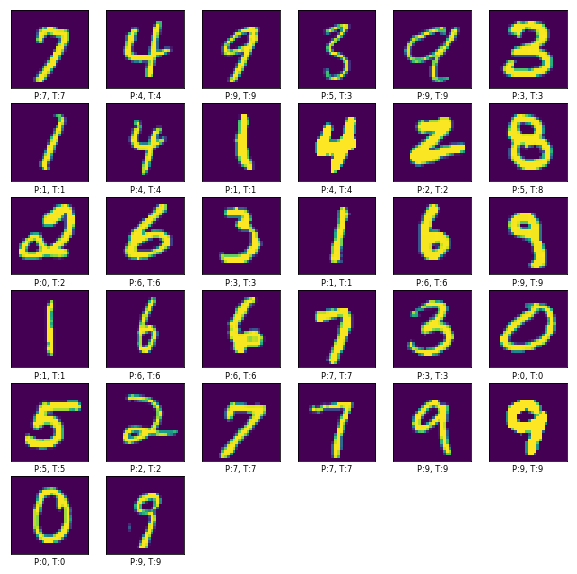

In [33]:
figsize(10,10)
eval_data, eval_target = iter(test_loader).next()
eval_data  = eval_data[:32]
eval_target  = eval_target[:32]
show_batch(eval_data, eval_target, 
           tocpu(net(togpu(eval_data))).detach().argmax(1))

In [36]:
def compute_eval_loss(net, loader):
    # Evaluate the model
    with torch.no_grad():
        eval_loss = 0.0
        for i, data in tqdm.tqdm(enumerate(loader),
                                 file = sys.stdout,
                                 desc='Evaluating',
                                 total=len(loader),
                                 leave=False):
            inputs, labels = data
            inputs, labels = togpu(inputs), togpu(labels)
            outputs = net(inputs)               # Predict
            loss = criterion(outputs, labels)   # Grade / Evaluate
            eval_loss += loss.item()
    eval_loss /= len(test_loader)
    return eval_loss

In [37]:
compute_eval_loss(net, test_loader)

0.47674085447128783

In [38]:
start_epoch = 0
num_epochs = 60
best_epoch = 0
best_eval_loss = float('inf')

In [39]:
import shutil

In [40]:
try:
    start_epoch = epoch
except:
    pass

for epoch in tqdm.tnrange(start_epoch, num_epochs):
    
    running_loss = 0.0
    tstart = time.time()
    
    # Update the model parameters
    for i, data in tqdm.tqdm(enumerate(train_loader), 
                             file = sys.stdout,
                             desc='Updating',
                             total=len(train_loader), 
                             leave=False):
        # get the inputs
        inputs, labels = data
        
        # Move them to the GPU
        inputs = togpu(inputs)
        labels = togpu(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
    running_loss /= len(train_loader)
    

    eval_loss = compute_eval_loss(net, test_loader)
    
    tend = time.time()
    
    # Save parameters
    torch.save(dict(epoch=epoch, 
                         loss=eval_loss,
                         parameters=net.state_dict(),
                         optimizer=optimizer.state_dict()),
                   'multilayer-checkpoint.pth.tar')
    
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_epoch = epoch
        shutil.copyfile('multilayer-checkpoint.pth.tar', 'multilayer-best.pth.tar')
        
    print("Epoch {: 4}   loss: {: 2.5f}  test-loss: {: 2.5}  time: {}".format(epoch,
                                                                                running_loss,
                                                                                eval_loss,
                                                                                tend-tstart))

Epoch    4   loss:  0.45546  test-loss:  0.43582  time: 2.3571982383728027
Epoch    5   loss:  0.42139  test-loss:  0.40755  time: 2.2524092197418213
Epoch    6   loss:  0.39685  test-loss:  0.38664  time: 2.288475751876831
Epoch    7   loss:  0.37824  test-loss:  0.37009  time: 2.2543179988861084
Epoch    8   loss:  0.36405  test-loss:  0.35678  time: 2.2920823097229004
Epoch    9   loss:  0.35151  test-loss:  0.34663  time: 2.3319952487945557
Epoch   10   loss:  0.34180  test-loss:  0.33614  time: 2.235107898712158
Epoch   11   loss:  0.33250  test-loss:  0.3276  time: 2.3132858276367188
Epoch   12   loss:  0.32466  test-loss:  0.32122  time: 2.2865562438964844
Epoch   13   loss:  0.31826  test-loss:  0.31384  time: 2.250001907348633
Epoch   14   loss:  0.31179  test-loss:  0.30872  time: 2.3304831981658936
Epoch   15   loss:  0.30631  test-loss:  0.30263  time: 2.344407081604004
Epoch   16   loss:  0.30049  test-loss:  0.29691  time: 2.590871810913086
Epoch   17   loss:  0.29573  te

# the GPU Utilization during training:
```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.77                 Driver Version: 390.77                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   40C    P2    58W / 250W |    539MiB / 11178MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   25C    P8     8W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  GeForce GTX 108...  Off  | 00000000:0C:00.0 Off |                  N/A |
| 20%   26C    P8     9W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   3  GeForce GTX 108...  Off  | 00000000:0E:00.0 Off |                  N/A |
| 20%   26C    P8     9W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0     38289      C   ...mianjc/anaconda3/envs/CSE470/bin/python   529MiB |
+-----------------------------------------------------------------------------+
```

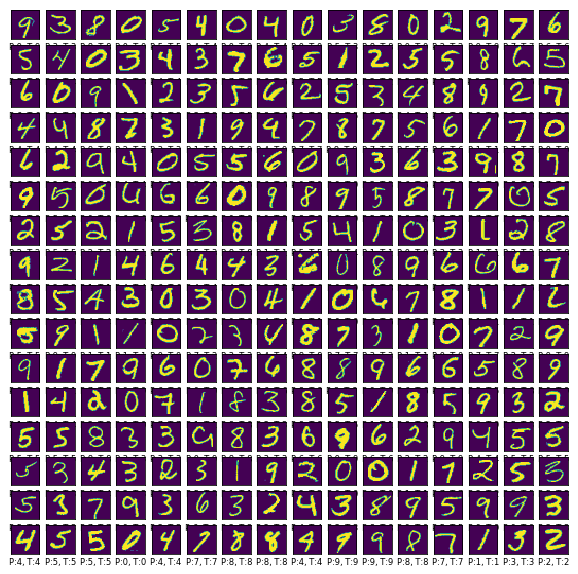

In [41]:
eval_data, eval_target = iter(test_loader).next()
show_batch(eval_data, eval_target, tocpu(net(togpu(eval_data))).detach().argmax(1))

In [42]:
predictions = np.zeros(len(test_data))
targets = np.zeros(len(test_data))

for i  in tqdm.tnrange(len(test_data)):
    x, t = test_data[i]
    p = tocpu(net(togpu(x[None,...]))).argmax(1)[0]
    predictions[i] = int(p)
    targets[i] = t

In [43]:
from sklearn.metrics import classification_report

/anaconda3/envs/cse627/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [44]:
print(classification_report(targets, predictions))

             precision    recall  f1-score   support

        0.0       0.96      0.98      0.97       980
        1.0       0.98      0.98      0.98      1135
        2.0       0.95      0.94      0.94      1032
        3.0       0.94      0.93      0.94      1010
        4.0       0.94      0.95      0.95       982
        5.0       0.93      0.93      0.93       892
        6.0       0.94      0.96      0.95       958
        7.0       0.95      0.94      0.95      1028
        8.0       0.94      0.92      0.93       974
        9.0       0.94      0.92      0.93      1009

avg / total       0.95      0.95      0.95     10000



In [45]:
class SimpleCNN(nn.Module):
    def __init__(self, shape=(28,28), num_classes=10):
        super().__init__()
        
        #num_inputs = np.product(shape)
      
        self.layer1 = nn.Conv2d(1,64, (3,3), padding=1) # 28 --> Pool --> 14
        self.layer2 = nn.Conv2d(64,64, (3,3), padding=1) # 14 --> Pool --> 7
        
        self.layer3 = nn.Linear(7*7*64,num_classes)
        
    
    def forward(self, x):        
        # width = 28
        
        x = self.layer1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # width = 14
        
        x = self.layer2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # width = 7
        
        # Flatten
        x = x.reshape(-1, 7*7*64)  
        y = self.layer3(x)
        
        return y  # Will learn to treat 'a' as the natural parameters of a multinomial distr. 

In [46]:
net = togpu(SimpleCNN())
optimizer = torch.optim.SGD(params=net.parameters(), lr=LEARNING_RATE)
start_epoch = 0
num_epochs = 60

In [47]:
for epoch in tqdm.tnrange(start_epoch, num_epochs):
    
    running_loss = 0.0
    tstart = time.time()
    
    # Update the model parameters
    for i, data in tqdm.tqdm(enumerate(train_loader), 
                             file = sys.stdout,
                             desc='Updating',
                             total=len(train_loader), 
                             leave=False):
        # get the inputs
        inputs, labels = data
        
        # Move them to the GPU
        inputs = togpu(inputs)
        labels = togpu(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
    running_loss /= len(train_loader)
    

    eval_loss = compute_eval_loss(net, test_loader)
    
    tend = time.time()
    
    # Save parameters
    torch.save(dict(epoch=epoch, 
                         loss=eval_loss,
                         parameters=net.state_dict(),
                         optimizer=optimizer.state_dict()),
                   'simplecnn-checkpoint.pth.tar')
    
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_epoch = epoch
        shutil.copyfile('simplecnn-checkpoint.pth.tar', 'simplecnn-best.pth.tar')
        
    print("Epoch {: 4}   loss: {: 2.5f}  test-loss: {: 2.5}  time: {}".format(epoch,
                                                                                running_loss,
                                                                                eval_loss,
                                                                                tend-tstart))

Updating:  68%|██████▊   | 160/235 [00:59<00:29,  2.53it/s]

Process Process-1259:
Process Process-1257:
Process Process-1255:
Process Process-1253:
Process Process-1254:
Process Process-1258:
Process Process-1252:
Process Process-1251:
Process Process-1260:
Process Process-1256:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/envs/cse627/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/envs/cse627/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/envs/cse627/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/envs/cse627/lib/python3.7/multiprocessing/process.py", line 297, in _boo

  File "/anaconda3/envs/cse627/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/anaconda3/envs/cse627/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/anaconda3/envs/cse627/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "/anaconda3/envs/cse627/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/anaconda3/envs/cse627/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "/anaconda3/envs/cse627/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "/anaconda3/envs/cse627/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "/anaconda3/envs/cse627/lib/python3.7/multiprocessing/connection.py", line 920, in wait

Traceback (most recent call last):
  File "/anaconda3/envs/cse627/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-57c454acaa64>", line 23, in <module>
    outputs = net(inputs)               # Predict
  File "/anaconda3/envs/cse627/lib/python3.7/site-packages/torch/nn/modules/module.py", line 477, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-45-f03b67775f31>", line 23, in forward
    x = F.max_pool2d(x, 2)
  File "/anaconda3/envs/cse627/lib/python3.7/site-packages/torch/nn/functional.py", line 396, in max_pool2d
    ret = torch._C._nn.max_pool2d_with_indices(input, kernel_size, stride, padding, dilation, ceil_mode)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/envs/cse627/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 186

KeyboardInterrupt: 

In [ ]:
predictions = np.zeros(len(test_data))
targets = np.zeros(len(test_data))

for i  in tqdm.tnrange(len(test_data)):
    x, t = test_data[i]
    p = tocpu(net(togpu(x[None,...]))).argmax(1)[0]
    predictions[i] = int(p)
    targets[i] = t

In [ ]:
print(classification_report(targets, predictions, digits=3))